# Trabajo Práctico 3: Naive-Bayes

Como siempre, comenzamos importando las dependencias necesarias

In [63]:
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss, mean_squared_error
from sklearn.naive_bayes import GaussianNB
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay

# Ejercicio 1

En este ejercicio compararemos el desempeño de Naive Bayes contra las redes neuronales y los árboles de decisión.

Primero, incluimos el código de la función `entrenar_red_sin_val` del TP anterior, que usaremos para entrenar la red neuronal.

In [3]:
def entrenar_red_sin_val(red, evaluaciones, X_train, y_train, X_test, y_test):

     if (isinstance(red, MLPClassifier)):
          metric = zero_one_loss
     elif (isinstance(red, MLPRegressor)):
          metric = mean_squared_error

     best_red = None
     best_score = float('inf')
     error_train = []
     weight_sum = []
     error_test = []

     for i in range(evaluaciones):
          red.fit(X_train, y_train)
          train = metric(y_train, red.predict(X_train))
          if train < best_score:
               best_score = train
               best_red = deepcopy(red)
          error_train.append(metric(y_train, red.predict(X_train)))
          weight_sum.append(sum(np.sum(np.square(w)) + np.sum(np.square(b)) for w, b in zip(red.coefs_, red.intercepts_)))
          error_test.append(metric(y_test, red.predict(X_test)))

     return best_red, error_train, weight_sum, error_test

Incluimos tambien el código para generar los datos, originalmente perteneciente al TP0.

In [4]:
def diagonal(d, n, C):
  df = pd.DataFrame(np.random.normal(-1, C * np.sqrt(d), (n // 2, d))) # Con esto generamos n//2 filas con d valores aleatorios centrados en -1 cada una
  df["Output"] = 0 # Con esto les asignamos a las filas generadas la clase 0
  df2 = pd.DataFrame(np.random.normal(1, C * np.sqrt(d), (n - (n // 2), d))) # Generamos la otra mitad de puntos, centrados en 1
  df2["Output"] = 1 # Les asignamos la clase 1
  final = pd.concat([df, df2])
  final.Output = final.Output.astype('category') # Le decimos a Pandas que interprete la columna "Output" como una categoría
  return final.sample(frac=1, ignore_index=True) # Reordenamos aleatoriamente las filas

def paralelo(d, n, C):
  v0 = [-1] + [0] * (d - 1)
  v1 = [1] + [0] * (d - 1)
  df = pd.DataFrame(np.random.normal(v0, [C] * d, (n // 2, d))) # Con esto generamos n//2 filas con d valores aleatorios centrados en la componente correspondiente de v0
  df["Output"] = 0 # Con esto les asignamos a las filas generadas la clase 0
  df2 = pd.DataFrame(np.random.normal(v1, [C] * d, (n - (n // 2), d))) # Generamos la otra mitad de puntos, centrados en v1
  df2["Output"] = 1 # Les asignamos la clase 1
  final = pd.concat([df, df2])
  final.Output = final.Output.astype('category') # Le decimos a Pandas que interprete la columna "Output" como una categoría
  return final.sample(frac=1, ignore_index=True) # Reordenamos aleatoriamente las filas

Por último, entrenamos los 3 tipos de modelos y comparamos su desempeño en un gráfico. Este gráfico es una modificación de uno incluido en el TP anterior, donde sólo comparábamos los árboles de decisión y las redes neuronales. El código añadido entrena clasificadores Naive Bayes para ambos problemas e incluye sus resultados en el gráfico.

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.wa

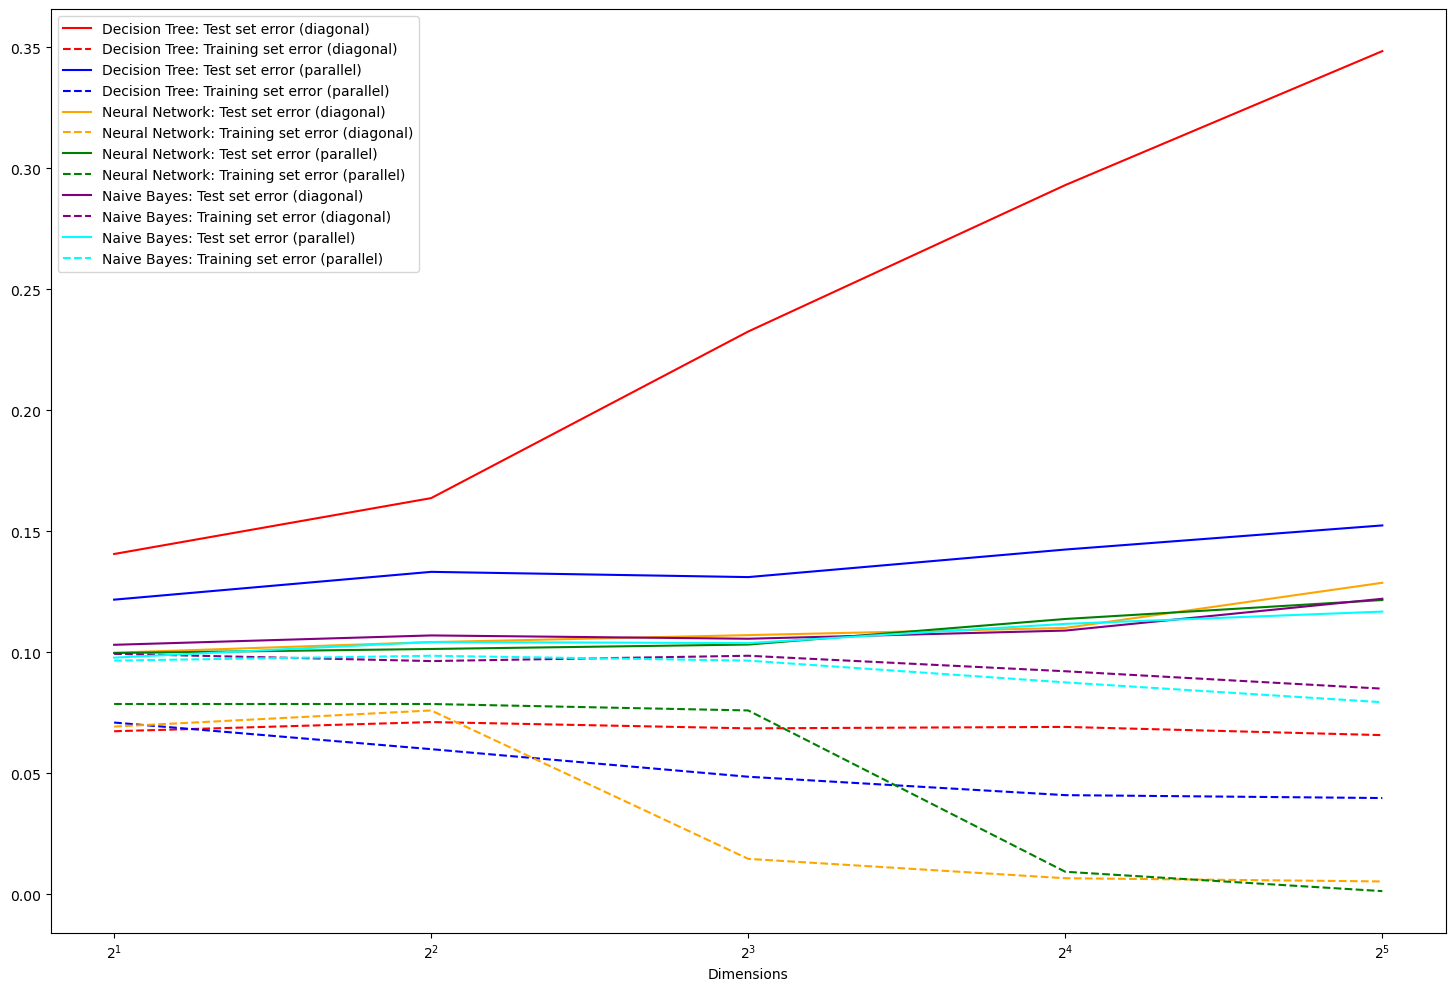

In [8]:
d_values = [2,4,8,16,32]

diag_stats = []

for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  for k in range(20):
    training_set = diagonal(d, 250, 0.78)
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    clf.fit(training_set[list(range(0, d))], training_set["Output"])
    diag_stats.append({"Dimensions": d, "training set error": (1 - clf.score(training_set[list(range(0, d))], training_set["Output"])), "test set error": (1 - clf.score(test_set[list(range(0, d))], test_set["Output"]))})

parallel_stats = []

for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  for k in range(20):
    training_set = paralelo(d, 250, 0.78)
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    clf.fit(training_set[list(range(d))], training_set["Output"])
    parallel_stats.append({"Dimensions": d, "training set error": (1 - clf.score(training_set[list(range(0, d))], training_set["Output"])), "test set error": (1 - clf.score(test_set[list(range(0, d))], test_set["Output"]))})

diag_stats = pd.DataFrame(diag_stats).groupby("Dimensions", as_index=False).mean()

parallel_stats = pd.DataFrame(parallel_stats).groupby("Dimensions", as_index=False).mean()

# ---Neural Networks---

diag_train_stats = []
diag_test_stats = []
for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  X_test, y_test = test_set[list(range(d))], test_set["Output"]
  best_train = 0
  best_test = 0
  for k in range(3):
    train_set = diagonal(d, 250, 0.78)
    X_train, y_train = train_set[list(range(d))], train_set["Output"]
    red = MLPClassifier(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.001, batch_size=1, learning_rate='constant', learning_rate_init=0.01, momentum=0.3, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=20)
    red, e_train, _, e_test = entrenar_red_sin_val(red, 300, X_train, y_train, X_test, y_test)
    best_train += pd.Series(e_train).min()
    best_test += pd.Series(e_test).min()
  best_train /= 3
  best_test /= 3
  diag_train_stats.append(best_train)
  diag_test_stats.append(best_test)

parallel_train_stats = []
parallel_test_stats = []
for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  X_test, y_test = test_set[list(range(d))], test_set["Output"]
  best_train = 0
  best_test = 0
  for k in range(3):
    train_set = paralelo(d, 250, 0.78)
    X_train, y_train = train_set[list(range(d))], train_set["Output"]
    red = MLPClassifier(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.001, batch_size=1, learning_rate='constant', learning_rate_init=0.01, momentum=0.3, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=20)
    red, e_train, _, e_test = entrenar_red_sin_val(red, 300, X_train, y_train, X_test, y_test)
    best_train += pd.Series(e_train).min()
    best_test += pd.Series(e_test).min()
  best_train /= 3
  best_test /= 3
  parallel_train_stats.append(best_train)
  parallel_test_stats.append(best_test)

# ---Neural Networks---

# ---Naive Bayes---
diag_stats_NB = []

for d in d_values:
  test_set = diagonal(d, 10000, 0.78)
  for k in range(20):
    training_set = diagonal(d, 250, 0.78)
    clf = GaussianNB()
    clf.fit(training_set[list(range(0, d))], training_set["Output"])
    diag_stats_NB.append({"Dimensions": d, "training set error": (1 - clf.score(training_set[list(range(0, d))], training_set["Output"])), "test set error": (1 - clf.score(test_set[list(range(0, d))], test_set["Output"]))})

parallel_stats_NB = []

for d in d_values:
  test_set = paralelo(d, 10000, 0.78)
  for k in range(20):
    training_set = paralelo(d, 250, 0.78)
    clf = GaussianNB()
    clf.fit(training_set[list(range(d))], training_set["Output"])
    parallel_stats_NB.append({"Dimensions": d, "training set error": (1 - clf.score(training_set[list(range(0, d))], training_set["Output"])), "test set error": (1 - clf.score(test_set[list(range(0, d))], test_set["Output"]))})

diag_stats_NB = pd.DataFrame(diag_stats_NB).groupby("Dimensions", as_index=False).mean()

parallel_stats_NB = pd.DataFrame(parallel_stats_NB).groupby("Dimensions", as_index=False).mean()

# ---Naive Bayes---

diag_ax = diag_stats.plot.line(x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="red", logx=True, figsize=(15, 10))
parallel_stats.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="blue", logx=True)
diag_ax.plot(d_values, diag_test_stats, color="orange", linestyle="-")
diag_ax.plot(d_values, diag_train_stats, color="orange", linestyle="--")
diag_ax.plot(d_values, parallel_test_stats, color="green", linestyle="-")
diag_ax.plot(d_values, parallel_train_stats, color="green", linestyle="--")
diag_stats_NB.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="purple", logx=True)
parallel_stats_NB.plot.line(ax=diag_ax, x="Dimensions", y=[ "test set error", "training set error" ], style=["-", "--"], color="cyan", logx=True)
diag_ax.legend(labels=[
  "Decision Tree: Test set error (diagonal)",
  "Decision Tree: Training set error (diagonal)",
  "Decision Tree: Test set error (parallel)",
  "Decision Tree: Training set error (parallel)",
  "Neural Network: Test set error (diagonal)",
  "Neural Network: Training set error (diagonal)",
  "Neural Network: Test set error (parallel)",
  "Neural Network: Training set error (parallel)",
  "Naive Bayes: Test set error (diagonal)",
  "Naive Bayes: Training set error (diagonal)",
  "Naive Bayes: Test set error (parallel)",
  "Naive Bayes: Training set error (parallel)"
  ])
diag_ax.set_xscale("log", base=2)

Como vemos en el gráfico, el error con el clasificador Naive Bayes resulta ser muy similar en el conjunto de test al desempeño de las redes neuronales. La diferencia que notamos con respecto a las redes neuronales, sin embargo, es su peor desempeño en el conjunto de training. Esto podría parecer malo, pero en realidad lo que estamos viendo es una menor diferencia entre el desempeño en los conjuntos de training y test. Esto quiere decir que estamos obteniendo un menor grado de sobreajuste, lo cual es de hecho deseable.

# Ejercicio 2

En este ejercicio exploraremos situaciones límite en las que Naive Bayes es propenso a aprender clasificaciones erróneas.

La primer situación que veremos se exhibe con el dataset `dos_elipses`. Compararemos el desempeño de Naive Bayes en esta tarea respecto al de una red neuronal. Para eso, incluimos otro fragmento de código del TP anterior que utilizaremos para entrenar dicha red.

In [4]:
#función que entrena una red ya definida previamente "evaluaciones" veces, cada vez entrenando un número de épocas elegido al crear la red y midiendo el error en train, validación y test al terminar ese paso de entrenamiento. 
#Guarda y devuelve la red en el paso de evaluación que da el mínimo error de validación
#entradas: la red, las veces que evalua, los datos de entrenamiento y sus respuestas, de validacion y sus respuestas, de test y sus respuestas
#salidas: la red entrenada en el mínimo de validación, los errores de train, validación y test medidos en cada evaluación
def entrenar_red(red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test):

     if (isinstance(red, MLPClassifier)):
          metric = zero_one_loss
     elif (isinstance(red, MLPRegressor)):
          metric = mean_squared_error

     best_red = None
     best_score = float('inf')
     error_train = []
     error_val = []
     error_test = []

     for i in range(evaluaciones):
          red.fit(X_train, y_train)
          error_train.append(metric(y_train, red.predict(X_train)))
          val = metric(y_val, red.predict(X_val))
          if val < best_score:
               best_score = val
               best_red = deepcopy(red)
          error_val.append(val)
          error_test.append(metric(y_test, red.predict(X_test)))

     return best_red, error_train, error_val, error_test

Hecho esto, procedemos a entrenar un modelo de Naive Bayes y una red neuronal con este dataset. Graficamos para cada modelo sus predicciones en el conjunto de test. Adicionalmente, graficamos tambien la clasificación correcta para poder compararla con las aprendidas.

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


<Axes: title={'center': 'Correct Classes'}>

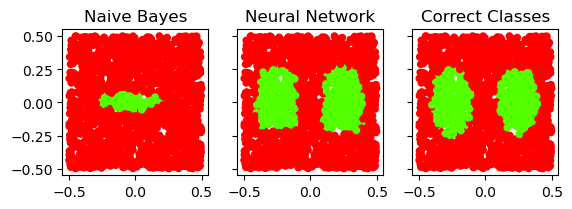

In [22]:
train_and_val, test = (pd.read_csv("dos_elipses.data", header=None).sample(500), pd.read_csv("dos_elipses.test", header=None))
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(train_and_val[[0, 1]], train_and_val[2], test_size=0.2)
X_test, y_test = test[[0, 1]], test[2]

fig, ax = plt.subplots(1, 3, sharey=True)
ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
ax[2].set_box_aspect(1)
nb = GaussianNB()
nb.fit(X_train, y_train)
red = MLPClassifier(hidden_layer_sizes=(20,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=0.1, momentum=0.9, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=20)
red, e_train, e_val, e_test = entrenar_red(red, 1000, X_train, y_train, X_val, y_val, X_test, y_test)
p = X_test.copy()
p.insert(loc=2, column="Pred", value=red.predict(X_test))
p.insert(loc=3, column="PredNB", value=nb.predict(X_test))
p.insert(loc=4, column="Expected", value=y_test)
p.Pred = p.Pred.astype("category")
p.PredNB = p.PredNB.astype("category")
p.Expected = p.Expected.astype("category")
p.plot.scatter(ax=ax[0], x=0, y=1, c="PredNB", cmap="prism", colorbar=False, xlabel="", ylabel="", title="Naive Bayes")
p.plot.scatter(ax=ax[1], x=0, y=1, c="Pred", cmap="prism", colorbar=False, xlabel="", ylabel="", title="Neural Network")
p.plot.scatter(ax=ax[2], x=0, y=1, c="Expected", cmap="prism", colorbar=False, xlabel="", ylabel="", title="Correct Classes")

Podemos ver que el clasificador Naive Bayes fracasa en la tarea. Esto muy probablemente se deba a una de las premisas que supone Naive Bayes: que cada variable presenta una distribución gaussiana. Para el eje Y, esto no supondría un problema muy grave, pero en el eje X la distribución real está muy lejos de ser gaussiana. En particular para la clase en verde (las dos elipses), la distribución en el eje X tiene un grupo de datos a la izquierda y otro a la derecha, sin ninguno en el medio. Aproximar esta distribución con una gaussiana siempre nos traerá un error considerable, sobre todo en el área del medio. Es por esto que Naive Bayes termina clasificando una región muy pequeña con la clase verde, o en algunos casos directamente clasifica todo con la clase roja.

Ahora veremos la clasificación aprendida para el problema de `espirales-anidadas`. Para eso, primero debemos incluir el código que genera este dataset, originalmente hecho para el TP0.

In [18]:
def rand_polar_in_unit_circle():
  return (np.sqrt(np.random.uniform()), 2 * np.pi * np.random.uniform())

def polar_to_cartesian(rho, theta):
  return { "x": rho * np.cos(theta), "y": rho * np.sin(theta) }

def spirals(n):
  def is_between_curves(r, t): # Función para comprobar si ciertas coordenadas polares corresponden a un punto dentro de la curva (Clase 0)
    result = False
    while not result and r > 0: # Como nuestros ángulos van hasta 2pi, hay que restar iterativamente una 'vuelta completa' para ver si el punto está en la curva
      result = (t / (4 * np.pi)) <= r and r < ((t + np.pi) / (4 * np.pi))
      r -= 0.5
    return result

  vals = []
  while len(vals) < n//2:
    x = rand_polar_in_unit_circle()
    if(is_between_curves(*x)):
      vals.append(polar_to_cartesian(*x) | {"Output": 0})

  while len(vals) < n:
    x = rand_polar_in_unit_circle()
    if(not is_between_curves(*x)):
      vals.append(polar_to_cartesian(*x) | {"Output": 1})

  df = pd.DataFrame(vals)
  df.Output = df["Output"].astype('category')
  return df.sample(frac=1, ignore_index=True) # Reordenamos aleatoriamente las filas

Ahora sí, entrenamos un clasificador Naive Bayes y una red neuronal, y graficamos sus predicciones sobre el conjunto de test de manera similar a lo realizado para `dos_elipses`.

/home/lautarog/anaconda3/envs/iaa/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


<Axes: title={'center': 'Correct Classes'}>

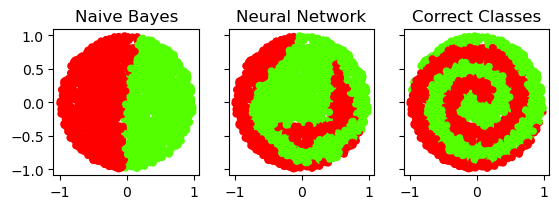

In [26]:
train_and_val = spirals(600)
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(train_and_val[["x", "y"]], train_and_val.Output, test_size=0.2)
test = spirals(2000)
X_test, y_test = test[["x", "y"]], test.Output

fig, ax = plt.subplots(1, 3, sharey=True)
ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
ax[2].set_box_aspect(1)
nb = GaussianNB()
nb.fit(X_train, y_train)
red = MLPClassifier(hidden_layer_sizes=(20,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=0.1, momentum=0.9, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=20)
red, e_train, e_val, e_test = entrenar_red(red, 1000, X_train, y_train, X_val, y_val, X_test, y_test)
p = X_test.copy()
p.insert(loc=2, column="Pred", value=red.predict(X_test))
p.insert(loc=3, column="PredNB", value=nb.predict(X_test))
p.insert(loc=4, column="Expected", value=y_test)
p.Pred = p.Pred.astype("category")
p.PredNB = p.PredNB.astype("category")
p.Expected = p.Expected.astype("category")
p.plot.scatter(ax=ax[0], x="x", y="y", c="PredNB", cmap="prism", colorbar=False, xlabel="", ylabel="", title="Naive Bayes")
p.plot.scatter(ax=ax[1], x="x", y="y", c="Pred", cmap="prism", colorbar=False, xlabel="", ylabel="", title="Neural Network")
p.plot.scatter(ax=ax[2], x="x", y="y", c="Expected", cmap="prism", colorbar=False, xlabel="", ylabel="", title="Correct Classes")

En el gráfico vemos que Naive Bayes aprende una clasificación bastante extraña. En la mayoría de ejecuciones, aprende a dividir las clases según una línea más o menos recta que pasa por el centro del círculo. Como dijimos en el ejemplo anterior, los clasificadores de Naive Bayes asumen que las variables están distribuidas de manera independiente y se rigen por una distribución gaussiana, con un medio y una varianza diferentes según la variable. Observando la distribución de puntos en el espiral, podemos imaginarnos que el clasificador Naive Bayes aprende que la clase roja genera puntos uniformemente en un círculo que está ligeramente abajo y a la izquierda del centro del círculo real, y que la clase verde hace lo mismo pero hacia arriba y a la derecha. De esta manera, el clasificador ideal para esta distribución sería efectivamente una recta perpendicular al segmento determinado por los dos medios de las distribuciones. Dónde caen exactamente estos dos medios de las distribuciones varía según la ejecución, pero como vemos la tendencia es que haya más puntos rojos abajo a la izquierda y más puntos verdes arriba a la derecha. La razón principal por la que esta es la mejor solución que Naive Bayes puede encontrar es que asume las variables como independientes, con lo cual jamás podrá aprender la fuerte correlación que hay entre la coordenada x e y en este problema.

# Ejercicio 3

En este ejercicio desarrollamos una función para entrenar un modelo Naive Bayes con histogramas.

Definimos la función `entrenar_NB_discreto` que dados conjuntos de train, validación y test, junto con un array especificando los distintos valores que se quieren probar para la cantidad de bins del histograma, entrena clasificadores con los distintos valores para el discretizador y devuelve el mejor modelo (según el error en validación), así como tambien los valores de error en cada conjunto para cada modelo probado.

In [32]:
def entrenar_NB_discreto(X_train, y_train, X_val, y_val, X_test, y_test, bins_values=[5]):
  best_clf = None
  best_disc = None
  best_score = float('inf')
  error_train = []
  error_val = []
  error_test = []
  for bins in bins_values:
    disc = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    disc.fit(X_train)
    
    X_train_discreto = disc.transform(X_train.copy())
    X_val_discreto = disc.transform(X_val.copy())
    X_test_discreto = disc.transform(X_test.copy())
    
    clf = CategoricalNB(min_categories=bins)

    clf.fit(X_train_discreto, y_train)

    error_train.append(zero_one_loss(y_train, clf.predict(X_train_discreto)))
    val = zero_one_loss(y_val, clf.predict(X_val_discreto))
    if val < best_score:
      best_score = val
      best_clf = deepcopy(clf)
      best_disc = deepcopy(disc)
    error_val.append(val)
    error_test.append(zero_one_loss(y_test, clf.predict(X_test_discreto)))

  return best_clf, best_disc, error_train, error_val, error_test

# Ejercicio 4

En este ejercicio entrenamos modelos Naive Bayes con histogramas para comparar su desempeño con los modelos basados en Gaussianas.

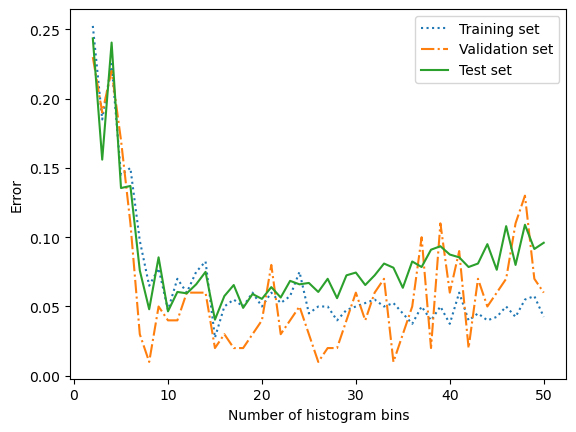

<Axes: title={'center': 'Predicted classes'}>

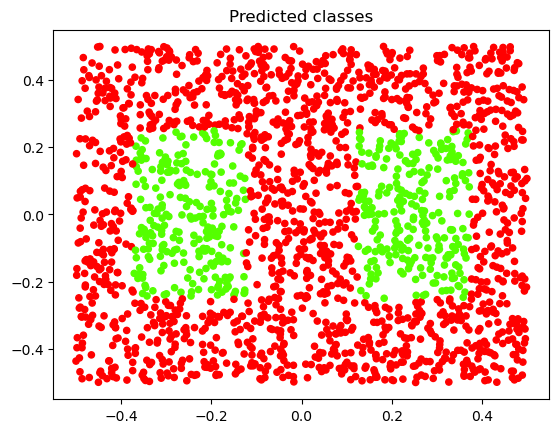

In [51]:
train_and_val, test = (pd.read_csv("dos_elipses.data", header=None).sample(500), pd.read_csv("dos_elipses.test", header=None))
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(train_and_val[[0, 1]], train_and_val[2], test_size=0.2)
X_test, y_test = test[[0, 1]], test[2]
bins_values = np.arange(2, 51)
best_clf, best_disc, error_train, error_val, error_test = entrenar_NB_discreto(X_train, y_train, X_val, y_val, X_test, y_test, bins_values=bins_values)

plt.plot(bins_values, error_train,label="Training set",linestyle=":")
plt.plot(bins_values, error_val,label="Validation set",linestyle="-.")
plt.plot(bins_values, error_test,label="Test set",linestyle="-")
plt.xlabel("Number of histogram bins")
plt.ylabel("Error")
plt.legend()
plt.show()

df = X_test.copy()
df.insert(loc=2, column="Pred", value=best_clf.predict(best_disc.transform(X_test)))
df.Pred = df.Pred.astype("category")
df.plot.scatter(x=0, y=1, c="Pred", cmap="prism", colorbar=False, xlabel="", ylabel="", title="Predicted classes")

Vemos que el error en test decrece hasta llegar a alrededor de 10 bins. Luego de eso, se mantiene más o menos estable y después empieza a ascender. Mientras asciende, el error en training se mantiene igual, con lo cual podemos concluir que en ese punto ya se está produciendo sobreajuste. En cuanto a la clasificación aprendida, vemos que es mucho más apropiada que la aprendida con gaussianas. Sin embargo, tambien notamos que tiene la particularidad de que todos sus bordes son rectos y alineados a los ejes. Esto es producto de la discretización que se aplica sobre los datos.

Ahora realizaremos la misma evaluación sobre el problema `espirales_anidadas`.

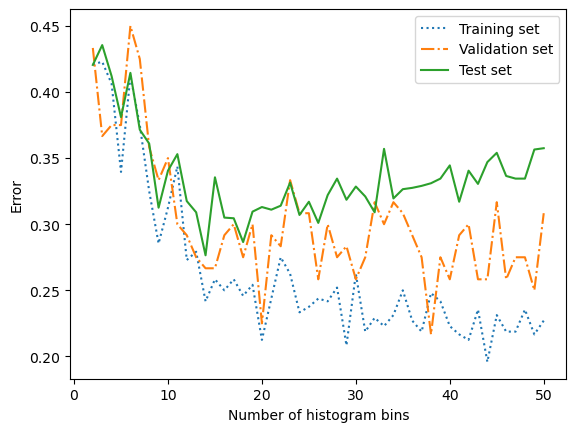

<Axes: title={'center': 'Predicted classes'}>

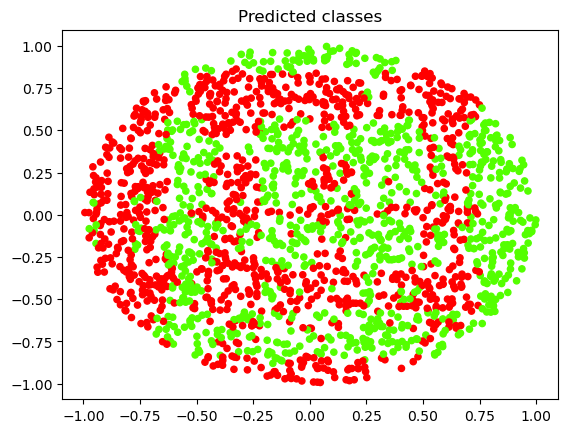

In [69]:
train_and_val = spirals(600)
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(train_and_val[["x", "y"]], train_and_val.Output, test_size=0.2)
test = spirals(2000)
X_test, y_test = test[["x", "y"]], test.Output
bins_values = np.arange(2, 51)
best_clf, best_disc, error_train, error_val, error_test = entrenar_NB_discreto(X_train, y_train, X_val, y_val, X_test, y_test, bins_values=bins_values)

plt.plot(bins_values, error_train,label="Training set",linestyle=":")
plt.plot(bins_values, error_val,label="Validation set",linestyle="-.")
plt.plot(bins_values, error_test,label="Test set",linestyle="-")
plt.xlabel("Number of histogram bins")
plt.ylabel("Error")
plt.legend()
plt.show()

df = X_test.copy()
df.insert(loc=2, column="Pred", value=best_clf.predict(best_disc.transform(X_test)))
df.Pred = df.Pred.astype("category")
df.plot.scatter(x="x", y="y", c="Pred", cmap="prism", colorbar=False, xlabel="", ylabel="", title="Predicted classes")

Como podemos ver en el gráfico de error, el desempeño mejora hasta alrededor de 20 bins y luego empeora, lo que indica sobreajuste. En cuanto a la clasificación aprendida, si bien no es ideal parece ser una solución más encaminada hacia la clasificación correcta, y que no presenta claros artefactos indicativos de una imposibilidad de aprender la solución ideal (más allá del problema de los bordes alineados a los ejes que mencionamos anteriormente)

# Ejercicio 5

En este ejercicio utilizamos clasificadores Naive Bayes para clasificar textos.

Cargaremos el dataset 20newsgroups y entrenaremos modelos variando los parámetros para la vectorización y para el alfa del clasificador. Guardamos el desempeño en validación de cada modelo entrenado. Buscamos el mejor clasificador y registramos su desempeño. Además, graficamos para este modelo su matriz de confusión, para poder evaluar el desempeño en cada clase.

,largo,alfa,val
0,1000,1.0000,0.353835
1,1000,0.1000,0.346059
2,1000,0.0100,0.346766
3,1000,0.0010,0.346766
4,1000,0.0001,0.349947
5,1500,1.0000,0.310710
6,1500,0.1000,0.300460
7,1500,0.0100,0.301873
8,1500,0.0010,0.303994
9,1500,0.0001,0.310004


Best model: alfa=0.1, largo=4000. Score: 0.23223753976670203 val, 0.2939458311205523 test


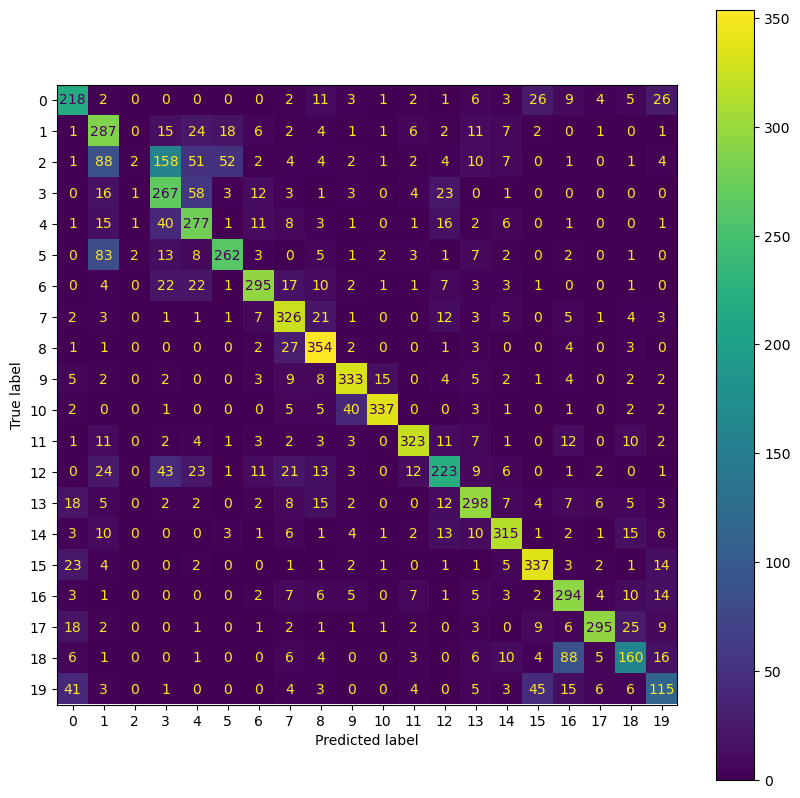

In [68]:
X, y = fetch_20newsgroups(subset="train",return_X_y=True, remove=["headers"])
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.25, random_state=1)
X_test, y_test = fetch_20newsgroups(subset="test",return_X_y=True,remove=["headers"])

largos = [1000, 1500, 2000, 2500, 3000, 3500, 4000]
alfas = [1, 0.1, 0.01, 0.001, 0.0001]

data = []
best_clf = None
best_vec = None
best_score = float('inf') 
best_largo = 0
best_alfa = 0
best_test = 0

for largo in largos:
  vec = CountVectorizer(stop_words='english',max_features=largo)
  Xvec_train = vec.fit_transform(X_train).toarray()
  Xvec_val = vec.transform(X_val).toarray()
  Xvec_test = vec.transform(X_test).toarray()
  for alfa in alfas:
    clf = MultinomialNB(alpha=alfa)
    clf.fit(Xvec_train, y_train)
    score = zero_one_loss(y_val, clf.predict(Xvec_val))
    if score < best_score:
      best_score = score
      best_clf = deepcopy(clf)
      best_vec = deepcopy(vec)
      best_largo = largo
      best_alfa = alfa
      best_test = zero_one_loss(y_test, clf.predict(Xvec_test))
    data.append({"largo": largo, "alfa": alfa, "val": score})

data = pd.DataFrame(data)
display(data)

print(f"Best model: alfa={best_alfa}, largo={best_largo}. Score: {best_score} val, {best_test} test")

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, best_clf.predict(best_vec.transform(X_test).toarray()), ax=ax)

De los datos obtenidos, vemos que la mejor combinación parece ser con un largo de diccionario de 4000, y un alfa de 0.1. El largo del diccionario pareciera siempre tener un impacto positivo en cuanto al desempeño, mientras que el valor ideal de alfa parece estar en el medio de las magnitudes probadas, cerca de 0.1. Para estos valores óptimos encontrados, no hay mucha distancia entre el error en validación y test, por lo que no parece haber sobreajuste. Según la matriz de confusión, vemos que la mayoría de las clases son predichas con poco error, excepto por la clase 2, la cual nuestro modelo parece muy reacio a asignar. En su lugar, tiende a asignarle a textos de esta clase las clases 1 y 3.

# Ejercicio 6

En este ejercicio no hay nada porque me quedé sin tiempo para hacerlo :(